# BelgiumTS - Belgian Traffic Sign Dataset 


## CNN

### For Google Drive

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
local_zip = '/content/drive/MyDrive/Computer_Vision_Duth/imagedb_btsd/imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_path = '/content/imagedb'
test_path = '/content/imagedb_test'

### Train the model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import zipfile

!rm /content/download
!rm -r /content/imagedb/
!rm -r /content/imagedb_test
!wget https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
local_zip = '/content/download'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

train_path = '/content/imagedb'
test_path = '/content/imagedb_test'

rm: cannot remove '/content/download': No such file or directory
rm: cannot remove '/content/imagedb/': No such file or directory
rm: cannot remove '/content/imagedb_test': No such file or directory
--2023-01-18 15:02:20--  https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
Resolving vc.ee.duth.gr (vc.ee.duth.gr)... 83.212.140.54
Connecting to vc.ee.duth.gr (vc.ee.duth.gr)|83.212.140.54|:6960... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181682323 (173M) [application/zip]
Saving to: ‘download’

download            100%[===================>] 173.27M  7.97MB/s    in 20s     

2023-01-18 15:02:42 (8.70 MB/s) - ‘download’ saved [181682323/181682323]



In [ ]:
batch_size = 64
epochs = 250
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_COLOR = 3
num_of_classes = 34

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=25, verbose=1)

# Checkpoints
checkpoint_filepath = '/content/drive/MyDrive/Computer_Vision_Duth/Belgian Traffic Sign Best Model/no_data_augmentation_my_belgian_traffic_signs.hdf5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

# Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
rescale = 1./255

train_image_generator = ImageDataGenerator(rescale=rescale, 
                                           validation_split=0.2)

test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', seed=1)

val_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', seed=1)

test_data_gen = test_image_generator.flow_from_directory(
        directory=test_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.
Found 2149 images belonging to 34 classes.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_diagrams(history, h=20, w=8):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(h, w))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x=train_data_gen, 
                    validation_data=val_data_gen, 
                    epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/250
39/39 [==============================] - 43s 702ms/step - loss: 3.2917 - accuracy: 0.0859 - val_loss: 3.1936 - val_accuracy: 0.1052 - lr: 0.0010
Epoch 2/250
39/39 [==============================] - 23s 580ms/step - loss: 3.2161 - accuracy: 0.1030 - val_loss: 3.1768 - val_accuracy: 0.1052 - lr: 0.0010
Epoch 3/250
39/39 [==============================] - 23s 589ms/step - loss: 2.5021 - accuracy: 0.2759 - val_loss: 1.6480 - val_accuracy: 0.4407 - lr: 0.0010
Epoch 4/250
39/39 [==============================] - 23s 600ms/step - loss: 1.3810 - accuracy: 0.5641 - val_loss: 1.1201 - val_accuracy: 0.6277 - lr: 0.0010
Epoch 5/250
39/39 [==============================] - 23s 589ms/step - loss: 0.6142 - accuracy: 0.8091 - val_loss: 0.5014 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 6/250
39/39 [==============================] - 23s 581ms/step - loss: 0.1390 - accuracy: 0.9634 - val_loss: 0.5809 - val_accuracy: 0.8998 - lr: 0.0010
Epoch 7/250
39/39 [==============================] - 23s 5

In [ ]:
train_loss, train_acc = model.evaluate(train_data_gen, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

39/39 - 7s - loss: 0.0239 - accuracy: 0.9910 - 7s/epoch - 183ms/step
Train accuracy: 99.10%


In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

34/34 - 8s - loss: 0.4068 - accuracy: 0.9339 - 8s/epoch - 243ms/step
Test accuracy: 93.39%


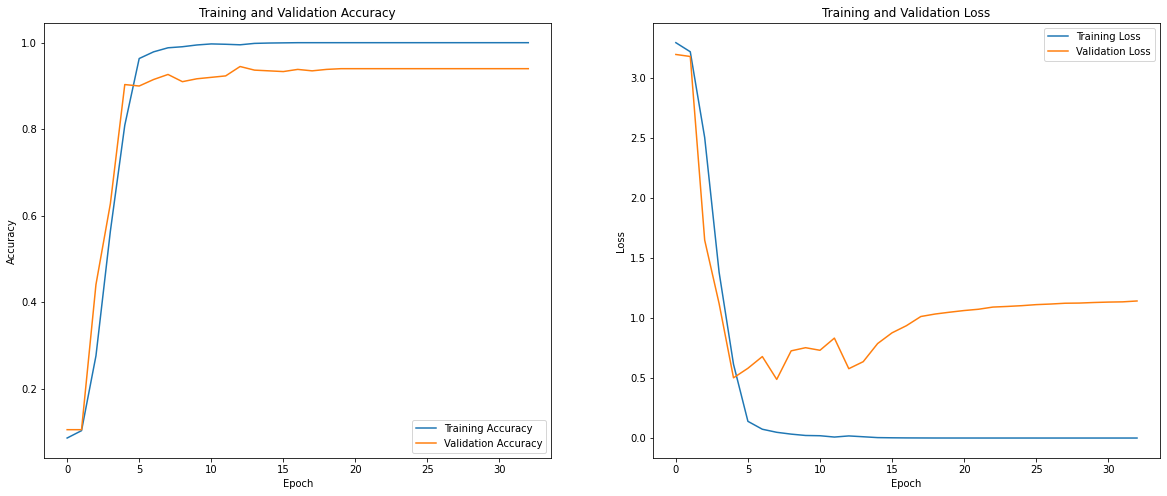

In [ ]:
plot_diagrams(history)

### Load the model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import load_model

# Checkpoints
checkpoint_filepath = '/content/drive/MyDrive/Computer_Vision_Duth/Belgian Traffic Sign Best Model/no_data_augmentation_my_belgian_traffic_signs.hdf5'

best_model = load_model(checkpoint_filepath)

In [ ]:
import zipfile
local_zip = '/content/drive/MyDrive/Computer_Vision_Duth/imagedb_btsd/imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_path = '/content/imagedb'
test_path = '/content/imagedb_test'

In [ ]:
batch_size = 64
epochs = 250
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_COLOR = 3
num_of_classes = 34

In [ ]:
rescale = 1./255

train_image_generator = ImageDataGenerator(rescale=rescale, 
                                           validation_split=0.2)

test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', seed=1)

val_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', seed=1)

test_data_gen = test_image_generator.flow_from_directory(
        directory=test_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.
Found 2149 images belonging to 34 classes.


In [ ]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 250, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 123, 123, 64)      18496     
                                                                 
 conv2d_4 (Conv2D)           (None, 121, 121, 64)      36928     
                                                        

In [ ]:
from keras.utils.layer_utils import count_params

trainable_params = count_params(best_model.trainable_weights)
non_trainable_params = count_params(best_model.non_trainable_weights)
print("Trainable params:", trainable_params)
print("Non trainable params:", non_trainable_params)

Trainable params: 2826530
Non trainable params: 0


In [ ]:
train_loss, train_acc = best_model.evaluate(train_data_gen, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

39/39 - 7s - loss: 0.0239 - accuracy: 0.9910 - 7s/epoch - 188ms/step
Train accuracy: 99.10%


In [ ]:
test_loss, test_acc = best_model.evaluate(test_data_gen, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

34/34 - 6s - loss: 0.4068 - accuracy: 0.9339 - 6s/epoch - 184ms/step
Test accuracy: 93.39%


## Pretrained model

### Train the model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
local_zip = '/content/drive/MyDrive/Computer_Vision_Duth/imagedb_btsd/imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_path = '/content/imagedb'
test_path = '/content/imagedb_test'

In [ ]:
batch_size = 64
epochs = 250
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_COLOR = 3
num_of_classes = 34

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, patience=25, verbose=1)

# Checkpoints
checkpoint_filepath = '/content/drive/MyDrive/Computer_Vision_Duth/Pretrained Belgian Traffic Sign Best Model/no_data_augmentation_my_belgian_traffic_signs.hdf5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

#Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [ ]:
rescale = 1./255

train_image_generator = ImageDataGenerator(rescale=rescale, 
                                           validation_split=0.2)

test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', seed=1)

val_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', seed=1)

test_data_gen = test_image_generator.flow_from_directory(
        directory=test_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.
Found 2149 images belonging to 34 classes.


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_diagrams(history, h=20, w=8):
    epochs = len(history.history['loss'])
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(h, w))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
# Create the base model from the pre-trained model ResNet50
base_model = tf.keras.applications.ResNet50(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_COLOR),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
len(base_model.layers)

175

In [ ]:
for i in range(len(base_model.layers)-50): 
  base_model.layers[i].trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 34)                4456482   
                                                                 
Total params: 28,044,194
Trainable params: 21,407,010
Non-trainable params: 6,637,184
_________________________________________________________________


In [ ]:
history = model.fit(x=train_data_gen, 
                    validation_data=val_data_gen, 
                    epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/250
39/39 [==============================] - 27s 558ms/step - loss: 9.0143 - accuracy: 0.0993 - val_loss: 2712.2725 - val_accuracy: 0.0267 - lr: 0.0010
Epoch 2/250
39/39 [==============================] - 21s 537ms/step - loss: 2.2485 - accuracy: 0.3753 - val_loss: 281.3454 - val_accuracy: 0.0234 - lr: 0.0010
Epoch 3/250
39/39 [==============================] - 20s 521ms/step - loss: 0.9845 - accuracy: 0.7236 - val_loss: 60.4340 - val_accuracy: 0.0234 - lr: 0.0010
Epoch 4/250
39/39 [==============================] - 20s 517ms/step - loss: 0.5226 - accuracy: 0.8486 - val_loss: 23.1956 - val_accuracy: 0.0885 - lr: 0.0010
Epoch 5/250
39/39 [==============================] - 20s 519ms/step - loss: 0.3111 - accuracy: 0.9121 - val_loss: 10.9150 - val_accuracy: 0.0985 - lr: 0.0010
Epoch 6/250
39/39 [==============================] - 20s 506ms/step - loss: 0.2364 - accuracy: 0.9292 - val_loss: 4.9643 - val_accuracy: 0.3339 - lr: 0.0010
Epoch 7/250
39/39 [==============================]

In [ ]:
train_loss, train_acc = model.evaluate(train_data_gen, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

39/39 - 10s - loss: 0.1756 - accuracy: 0.9544 - 10s/epoch - 260ms/step
Train accuracy: 95.44%


In [ ]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

34/34 - 10s - loss: 0.6834 - accuracy: 0.8357 - 10s/epoch - 291ms/step
Test accuracy: 83.57%


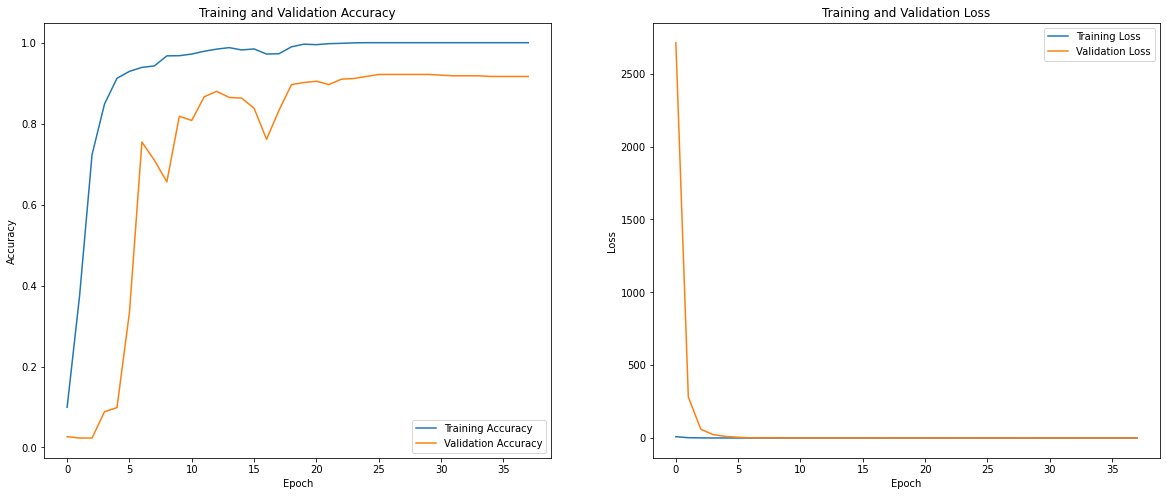

In [ ]:
plot_diagrams(history)

### Load the model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from keras.models import load_model

# Checkpoints
checkpoint_filepath = '/content/drive/MyDrive/Computer_Vision_Duth/Pretrained Belgian Traffic Sign Best Model/no_data_augmentation_my_belgian_traffic_signs.hdf5'

best_model = load_model(checkpoint_filepath)

In [ ]:
import zipfile
local_zip = '/content/drive/MyDrive/Computer_Vision_Duth/imagedb_btsd/imagedb_btsd.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
train_path = '/content/imagedb'
test_path = '/content/imagedb_test'

In [ ]:
batch_size = 64
epochs = 250
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_COLOR = 3
num_of_classes = 34

In [ ]:
rescale = 1./255

train_image_generator = ImageDataGenerator(rescale=rescale, 
                                           validation_split=0.2)

test_image_generator = ImageDataGenerator(rescale=rescale)

train_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training', seed=1)

val_data_gen = train_image_generator.flow_from_directory(
        directory=train_path,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation', seed=1)

test_data_gen = test_image_generator.flow_from_directory(
        directory=test_path, 
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 2457 images belonging to 34 classes.
Found 599 images belonging to 34 classes.
Found 2149 images belonging to 34 classes.


In [ ]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 34)                4456482   
                                                                 
Total params: 28,044,194
Trainable params: 21,407,010
Non-trainable params: 6,637,184
_________________________________________________________________


In [ ]:
from keras.utils.layer_utils import count_params

trainable_params = count_params(best_model.trainable_weights)
non_trainable_params = count_params(best_model.non_trainable_weights)
print("Trainable params:", trainable_params)
print("Non trainable params:", non_trainable_params)

Trainable params: 21407010
Non trainable params: 6637184


In [ ]:
train_loss, train_acc = best_model.evaluate(train_data_gen, verbose=2)
print("Train accuracy: " + "{:.2f}".format(train_acc*100) + "%")

39/39 - 11s - loss: 0.1756 - accuracy: 0.9544 - 11s/epoch - 279ms/step
Train accuracy: 95.44%


In [ ]:
test_loss, test_acc = best_model.evaluate(test_data_gen, verbose=2)
print("Test accuracy: " + "{:.2f}".format(test_acc*100) + "%")

34/34 - 9s - loss: 0.6834 - accuracy: 0.8357 - 9s/epoch - 262ms/step
Test accuracy: 83.57%
